MOVIE  GENRE CLASSIFICATION

Create a machine learning model that can predict the genre of a
movie based on its plot summary or other textual information.
You can use techniques like TF-IDF or word embeddings with classifiers
such as Naive Bayes, Logistic Regression, or Support Vector
Machines.

In [167]:
import pandas as pd 
import warnings 
warnings.filterwarnings('ignore')

Loading Data

In [168]:
train = pd.read_csv("train_data.txt.zip" , sep=':::' , names = ['Title' , 'Genre' , 'Description']).reset_index(drop=True)
train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [169]:
test = pd.read_csv("test_data.txt.zip" , sep=':::' , names = ['Title' , 'Description']).reset_index(drop=True)
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [170]:
y_test = pd.read_csv("test_data_solution.txt.zip" , sep=':::' , names = ['Genre' , 'Description']).reset_index(drop=True)
y_test.head()

,Genre,Description
0,thriller,"L.R. Brane loves his life - his car, his apar..."
1,comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,documentary,One year in the life of Albin and his family ...
3,drama,"His father has died, he hasn't spoken with hi..."
4,drama,Before he was known internationally as a mart...


[EDA] EXploratory Data Analysis

In [171]:
train.shape

(54214, 3)

In [172]:
test.shape

(54200, 2)

In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [174]:
train.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [175]:
train.duplicated().sum()

0

In [176]:
train.isna().sum()

Title          0
Genre          0
Description    0
dtype: int64

Data Visualization


In [177]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
sns.set(style='whitegrid')

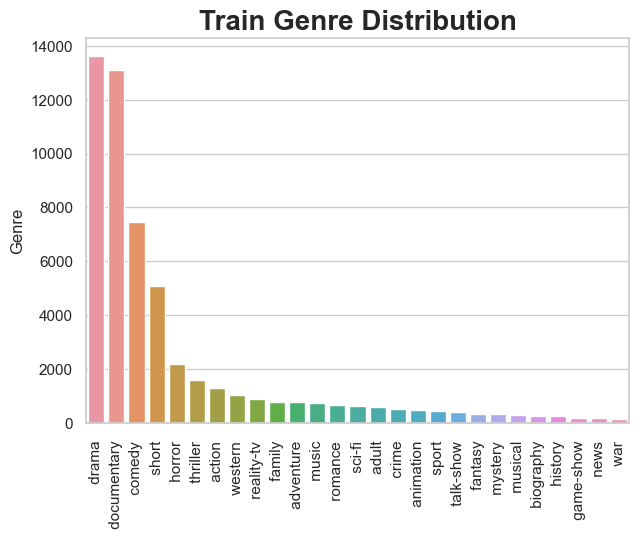

In [178]:
plt.figure(figsize=(7,5))
sns.barplot(x=train['Genre'].value_counts().index , y = train['Genre'].value_counts())
plt.title('Train Genre Distribution', fontsize = 20 , fontweight='bold')
plt.xticks(rotation = 90)
plt.show()

Data Cleaning

In [179]:
train['Description'].sample()

53469     Documentary-style reality series about a smal...
Name: Description, dtype: object

In [180]:
desc = train['Description']

twitter (@)

In [181]:
desc = desc[desc.str.contains(r'@\S+')]
desc.head()

242      Mail <svaradi@sprynet.com> for translation. T...
1880     Mail <svaradi@sprynet.com> for translation. F...
1986     Mail <svaradi@sprynet.com> for translation. S...
6579     Mail <svaradi@sprynet.com> for translation. D...
8296     Mail <svaradi@sprynet.com> for translation. 5...
Name: Description, dtype: object

In [182]:
desc = desc[desc.str.contains(r'http\S+')]
desc.head()


16974     Volume 1 of "The Happiness Matrix", a 2-hour ...
Name: Description, dtype: object

In [183]:
import re
import string
 
import nltk 


def clean_text(text):
    text = text.lower()
    text = re.sub('Mail <svaradi@sprynet.com> for translation.' , '',text)
    text = re.sub('-' , ' ',text)
    text = re.sub('r@\S+' , '',text)
    text = re.sub('rhttp\S+' , '',text)
    text = re.sub(f'[{string.punctuation}]' , '',text)
    text = re.sub(f'[{string.digits}]' , '',text)
    text = re.sub('r\S+' , '',text)
    text = re.sub('r\S+ , [a-zA-Z]\S+' , '',text)
    
    words = nltk.tokenize.word_tokenize(text,language='english' ,preserve_line=True)

    text =" ".join([i for i in words if  len (i)> 2])

    return text.strip()
  


In [184]:
train['c_description'] = train['Description'].apply(clean_text)
test['c_description'] = test['Description'].apply(clean_text)


In [185]:
train['c_description'].sample(5)

8968     not play upon the titles london evening newspa...
7562     maddy shows example the and blame that can put...
533      filmic about the ste jew and one hund yea film...
25832    young man accused his befo cha the police sets...
2251     bad seeds loving weste about bounty hunting ov...
Name: c_description, dtype: object

In [186]:
train['len_clean_desc'] = train['c_description'].apply(len)

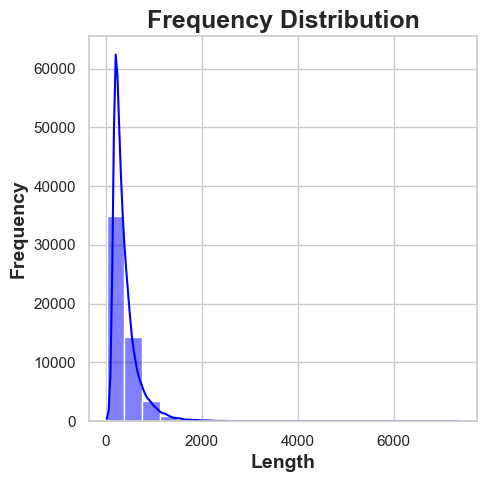

In [187]:
plt.figure(figsize=(5,5))
sns.histplot(data=train , x = 'len_clean_desc' , bins = 20 , kde = True , color ='blue')
plt.xlabel('Length', fontsize = 14 , fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14 , fontweight = 'bold')
plt.title('Frequency Distribution', fontsize = 18 , fontweight = 'bold')
plt.show()

Limiting the number of characters in Description

In [188]:
(train['len_clean_desc'] > 2000).value_counts()


False    54011
True       203
Name: len_clean_desc, dtype: int64

In [189]:
import numpy as np 
import random 

In [190]:
train['c_description'] = train['c_description'].apply(lambda x : x[:np.random.randint(500,2000)]if len(x) > 2000 else x)


In [191]:
train['len_clean_desc'] = train['c_description'].apply(len)

In [192]:
(train['len_clean_desc'] > 2000).value_counts()

False    54214
Name: len_clean_desc, dtype: int64

Dropping the neutral columns

In [193]:
x_train = train.drop(['Description' ,'len_clean_desc'] , axis=1 , inplace = True)

In [194]:
train['input'] = train['Title'] + " " + train['c_description']
test['input'] = test['Title'] + " " + test['c_description']


In [195]:
y_test = y_test['Genre']

Words embedding through tf-idf vectorizer

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf =TfidfVectorizer(stop_words='english' , max_features=35000)

In [197]:
x_train_transformed = tfidf.fit_transform(train['input'])
x_test_transformed = tfidf.fit_transform(test['input'])


Making Genre samples more balance 

In [198]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state=42)

In [199]:
x_train_resampled,y_train_resampled = sampler.fit_resample(x_train_transformed,train['Genre'])

In [200]:
x_train_resampled.shape

(367551, 35000)

In [201]:
y_train_resampled.shape


(367551,)

Label encoding of genres

In [202]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()

In [203]:
y_train_resampled=le.fit_transform(y_train_resampled)
y_test=le.fit_transform(y_test)

Model selection and training

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  MultinomialNB

lr = LogisticRegression()
mb = MultinomialNB()

In [209]:
from sklearn.model_selection import cross_val_score

scores_lr = cross_val_score(lr,x_train_resampled,y_train_resampled,cv=2)
np.average(scores_lr)




0.9230310927898999

In [210]:
scores_mb = cross_val_score(mb,x_train_resampled,y_train_resampled,cv=2)
np.average(scores_mb)

0.8797881136867739